In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/Users/alessandro.romualdi/projects/gionni/40_FPUT/fput/src


To dos
- Funzione che calcola l'energia totale sia con il Verlet che con il RK4, di modo che possiamo controllare l'errore relativo in %, i.e. (|E_tot, rk4 - E_tot, ver|/ E_tot, ver) *100
- Capire il perche dell errore numerico del nonzero energy per modo 2 in caso alpha e beta =0 


In [3]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.decomposition import PCA
#from sklearn.decomposition import KernelPCA
#from sklearn.manifold import LocallyLinearEmbedding

from sklearn.preprocessing import StandardScaler
#import plotly.express as px
from fput_integrator import FPUT_Integrator
from numpy import linalg as LA
from utils import (
    plot_mode_energies,
    create_input_data_vector,
    compute_explained_ratio,
    plot_consecutive_distances
)

# System inputs

In [4]:
NUM_ATOMS = 32  # number of particles equals to N in FPUT equations
T_MAX = 30000   # maximum time of simulation
INTEGRATION_TIME_STEP = 0.1
INITIAL_MODE_NUMBER = 1
NUM_MODES = 3  # number of modes to be observed
ALPHA_REF = 1
BETA_REF = 2

### Funcs

# Run FPU with verlet algo


## 1. Using alpha=0, beta=0 -> No Ergodicity

In [8]:
INITIAL_MODE_AMPLITUDE = 1

fpu = FPUT_Integrator(
    num_atoms=NUM_ATOMS,
    num_modes=5,
    initial_mode_number=1,
    initial_mode_amplitude=INITIAL_MODE_AMPLITUDE,
    t_step=0.4,
    t_max=T_MAX/10,
    alpha=0.0,
    beta=0.0
)

data_a_b_zero = fpu.run(method="verlet")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7499/7499 [00:04<00:00, 1710.73it/s]


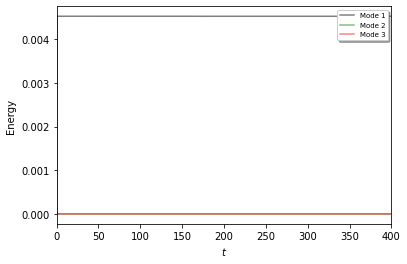

In [9]:
plot_mode_energies(data_a_b_zero, xlim=(0, 400))

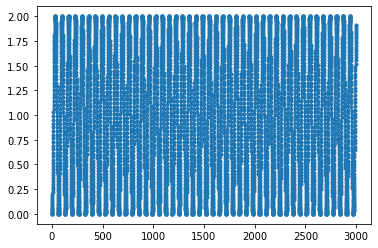

In [10]:
plot_consecutive_distances(data_a_b_zero, n_points=10000)

We observe that only the first two modes are excited. Moreover, because alpha and beta are both zero, there is no transfer of energy across modes and therefore their energy evolution in time are static.

### PCA

Explained variance ratio on all data: [5.00249518e-01 4.99750482e-01 7.49529663e-28 6.81908854e-28
 2.18655975e-28]


Text(0.5, 1.0, 'Explained variance ratios. Init amp = 1')

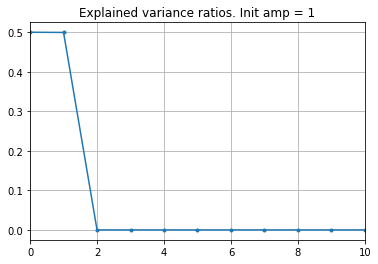

In [11]:
X_a_b_zero = create_input_data_vector(data_a_b_zero)

explained_variance_ratio = compute_explained_ratio(X_a_b_zero, pre_whitening=False)

plt.plot(explained_variance_ratio, ".-")
plt.xlim(0, 10)
plt.grid()
plt.title(f"Explained variance ratios. Init amp = {1}")

Only the first two PCs have significant (basically non-zero) explained variance ratio.

## 2. Using low initial mode amplitude -> No ergodicity

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112499/112499 [00:48<00:00, 2322.37it/s]


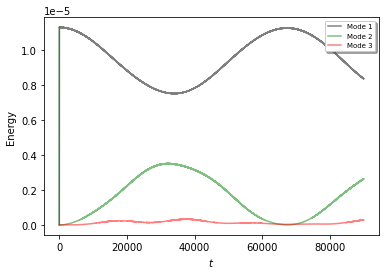

In [12]:
LOW_INITIAL_MODE_AMPLITUDE = 0.05

fpu = FPUT_Integrator(
    num_atoms=NUM_ATOMS,
    num_modes=NUM_MODES,
    initial_mode_number=INITIAL_MODE_NUMBER,
    initial_mode_amplitude=LOW_INITIAL_MODE_AMPLITUDE,
    t_step=0.8,
    t_max=3*T_MAX,
    alpha=ALPHA_REF,
    beta=BETA_REF
)

data_low_init_amp = fpu.run(method="verlet")

plot_mode_energies(data_low_init_amp)

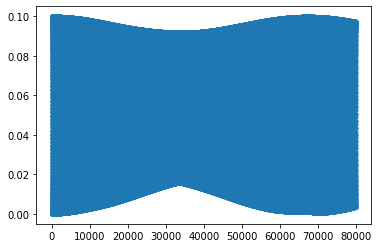

In [13]:
plot_consecutive_distances(data_low_init_amp, n_points=100000)

### PCA

Rank of covariance matrix of dim 64 is 21
Explained variance ratio on all data: [5.02138109e-01 4.97778645e-01 6.33712233e-05 1.98727650e-05
 1.95030394e-09]


Text(0.5, 1.0, 'Explained variance ratios. Init amp = 0.05')

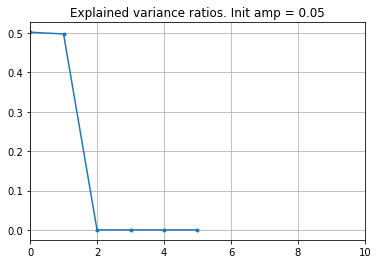

In [14]:
X_low_init_amp = create_input_data_vector(data_low_init_amp, sample_manifold=True)

explained_variance_ratio = compute_explained_ratio(X_low_init_amp, pre_whitening=True)

plt.plot(explained_variance_ratio, ".-")
plt.xlim(0, 10)
plt.grid()
plt.title(f"Explained variance ratios. Init amp = {LOW_INITIAL_MODE_AMPLITUDE}")

## Using higher initial mode amplitude -> Ergodicity

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37499/37499 [00:16<00:00, 2298.09it/s]


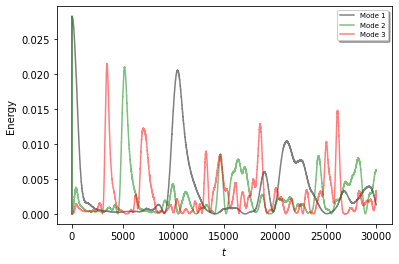

In [15]:
HIGH_INITIAL_MODE_AMPLITUDE = 2.5

fpu = FPUT_Integrator(
    num_atoms=NUM_ATOMS,
    num_modes=NUM_MODES,
    initial_mode_number=INITIAL_MODE_NUMBER,
    initial_mode_amplitude=HIGH_INITIAL_MODE_AMPLITUDE,
    t_step=0.8,
    t_max=T_MAX,
    alpha=ALPHA_REF,
    beta=BETA_REF
)

data_high_init_amp = fpu.run(method="verlet")

plot_mode_energies(data_high_init_amp)

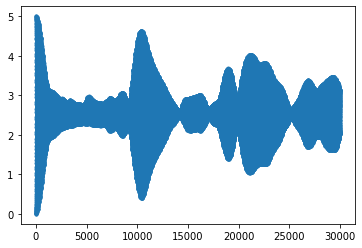

In [16]:
plot_consecutive_distances(data_high_init_amp, n_points=100000)

### PCA

Rank of covariance matrix of dim 64 is 64
Explained variance ratio on all data: [0.43286389 0.16232245 0.08046979 0.054489   0.04353926]


Text(0.5, 1.0, 'Explained variance ratios. Init amp = 0.05')

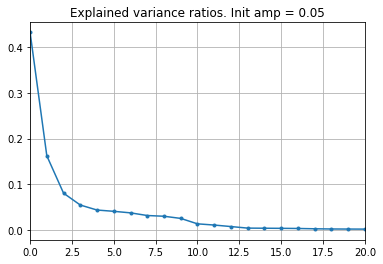

In [17]:
X_high_init_amp = create_input_data_vector(data_high_init_amp, sample_manifold=True)

explained_variance_ratio = compute_explained_ratio(X_high_init_amp, pre_whitening=True)

plt.plot(explained_variance_ratio, ".-")
plt.xlim(0, 20)
plt.grid()
plt.title(f"Explained variance ratios. Init amp = {LOW_INITIAL_MODE_AMPLITUDE}")

# Compute PCs vs initial energies

Here we compute the principal components, varyin the initial energy. Varying the initial energy from low to high, we expect phase transition between non-ergotic to ergotic. Therefore we ideally observe the PCs to have higher value to low component for low initial energy (ergotic) and more distributed values for high high energy (ergocit)

In [5]:
amplitude_range = np.arange(0.1, 2.5, 0.1, dtype=float)

data_dict = dict()

for initial_model_amplitude in amplitude_range:
    print("processing", initial_model_amplitude)
    fpu = FPUT_Integrator(
        num_atoms=NUM_ATOMS,
        num_modes=NUM_MODES,
        initial_mode_number=INITIAL_MODE_NUMBER,
        initial_mode_amplitude=initial_model_amplitude,
        t_step=0.2,
        t_max=T_MAX,
        alpha=ALPHA_REF,
        beta=BETA_REF
    )

    data = fpu.run(method="verlet")    
    data_dict[initial_model_amplitude] = data

processing 0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3827.56it/s]


processing 0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3815.20it/s]


processing 0.30000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3780.33it/s]


processing 0.4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3832.06it/s]


processing 0.5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:40<00:00, 3738.36it/s]


processing 0.6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:40<00:00, 3743.30it/s]


processing 0.7000000000000001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3813.35it/s]


processing 0.8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3833.36it/s]


processing 0.9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3770.48it/s]


processing 1.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3758.58it/s]


processing 1.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3759.54it/s]


processing 1.2000000000000002


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3831.55it/s]


processing 1.3000000000000003


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:38<00:00, 3859.54it/s]


processing 1.4000000000000001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3810.24it/s]


processing 1.5000000000000002


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:40<00:00, 3728.72it/s]


processing 1.6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3751.49it/s]


processing 1.7000000000000002


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:40<00:00, 3720.69it/s]


processing 1.8000000000000003


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:40<00:00, 3722.12it/s]


processing 1.9000000000000001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:44<00:00, 3391.88it/s]


processing 2.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3783.58it/s]


processing 2.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:40<00:00, 3738.45it/s]


processing 2.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3797.37it/s]


processing 2.3000000000000003


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:38<00:00, 3877.02it/s]


processing 2.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149999/149999 [00:39<00:00, 3844.34it/s]


In [13]:
import sys
print(f"Size of data_dict: {sys.getsizeof(data_dict)/(1024*1024)} MB")

Size of data_dict: 0.00112152099609375 MB


In [15]:
ls

__pycache__/ classes.py   script.py    utils.py


In [16]:
import pickle
with open('../notebooks/output/data_dict.pickle', 'wb') as handle:
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
with open('../notebooks/output/data_dict.pickle', 'rb') as handle:
    data_dict = pickle.load(handle)

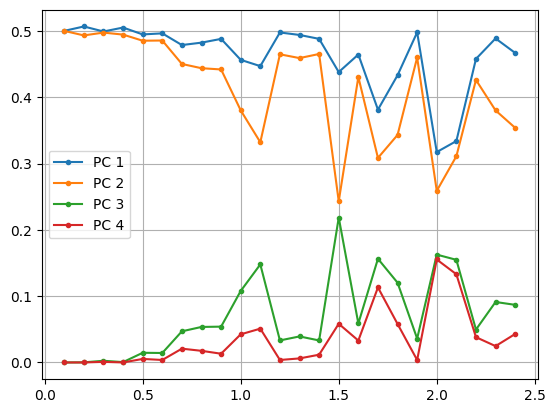

In [20]:
explained_variance_ratio_vs_energy = list()

for _, data in data_dict.items():
    
    X = create_input_data_vector(data, sample_manifold=True)

    explained_variance_ratio = compute_explained_ratio(
        X, pre_whitening=True, verbose=False)

    explained_variance_ratio_vs_energy.append(explained_variance_ratio[:4])


explained_variance_ratio_vs_energy_arr = np.array([x[:4] for x in explained_variance_ratio_vs_energy])

for i in range(4):
    plt.plot(
        amplitude_range,
        explained_variance_ratio_vs_energy_arr[:, i], ".-", label=f"PC {i+1}")
plt.legend()
plt.grid();

### Plot individual result for initial_model_amplitude

In [21]:
data_dict.keys()

dict_keys([0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000001, 1.5000000000000002, 1.6, 1.7000000000000002, 1.8000000000000003, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004])

Explained variance ratios. Init amp = 2.0


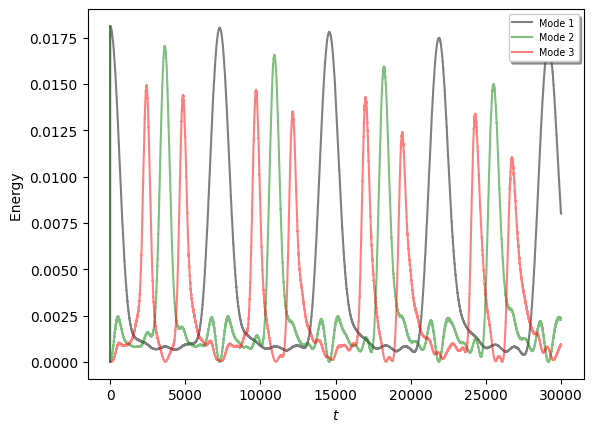

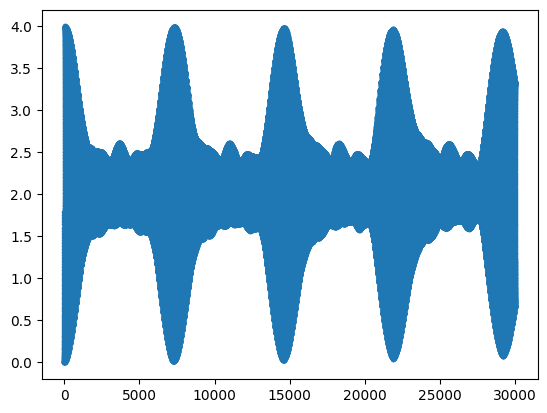

Rank of covariance matrix of dim 64 is 64
Explained variance ratio on all data: [0.33663531 0.30252801 0.15595091 0.13365401 0.04343333]


Text(0.5, 1.0, 'Explained variance ratios. Init amp = 2.0')

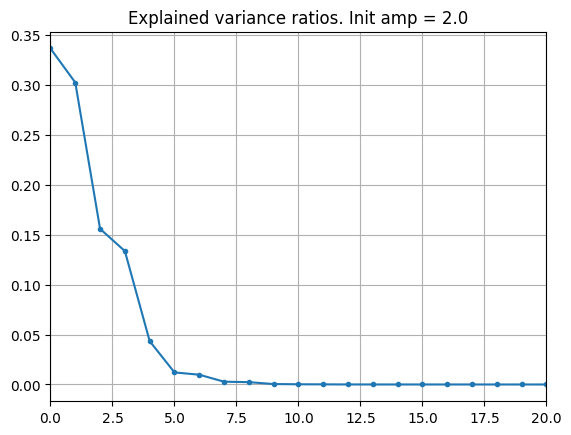

In [22]:
initial_model_amplitude = list(data_dict.keys())[-5]

this_data = data_dict[initial_model_amplitude]

print(f"Explained variance ratios. Init amp = {np.round(initial_model_amplitude, 2)}")

plot_mode_energies(this_data)
plt.show()

plot_consecutive_distances(this_data)
plt.show()

X = create_input_data_vector(this_data, sample_manifold=True)
this_explained_variance_ratio = compute_explained_ratio(X, pre_whitening=True)

plt.plot(this_explained_variance_ratio, ".-")
plt.xlim(0, 20)
plt.grid()
plt.title(f"Explained variance ratios. Init amp = {np.round(initial_model_amplitude, 2)}")